# Download images from GEE to modify snowline traces in QGIS

In [1]:
# Install necessary packages
!pip install geedim rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 28.3 MB/s eta 0:00:00


In [2]:
# Import packages
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
import geedim as gd
import os
import glob
import json
import math
from tqdm.auto import tqdm
import datetime
import rioxarray as rxr
import xarray as xr

In [4]:
# Authenticate your Google Earth Engine account
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

EEException: ignored

In [ ]:
# If using Google Colab, mount Google Drive so you can access the files in this folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# @title
# -----Define function for solving for optimal UTM zone
def convert_wgs_to_utm(lon: float, lat: float):
    """
    Return best UTM epsg-code based on WGS84 lat and lon coordinate pair

    Parameters
    ----------
    lon: float
        longitude coordinate
    lat: float
        latitude coordinate

    Returns
    ----------
    epsg_code: str
        optimal UTM zone, e.g. "32606"
    """
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0' + utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
        return epsg_code
    epsg_code = '327' + utm_band
    return epsg_code


# -----Define function for querying imagery
def query_gee_for_imagery(dataset_dict, dataset, aoi_utm, date_start, date_end, month_start, month_end,
                          cloud_cover_max, mask_clouds, out_path=None, im_download=False):
    """
    Query Google Earth Engine for Landsat 8 and 9 surface reflectance (SR), Sentinel-2 top of atmosphere (TOA) or SR imagery.
    Images captured within the hour will be mosaicked.

    Parameters
    __________
    dataset_dict: dict
        dictionary of parameters for each dataset
    dataset: str
        name of dataset ('Landsat', 'Sentinel-2_SR', 'Sentinel-2_TOA', 'PlanetScope')
    aoi_utm: geopandas.geodataframe.GeoDataFrame
        area of interest used for searching and clipping images
    date_start: str
        start date for image search ('YYYY-MM-DD')
    date_end: str
        end date for image search ('YYYY-MM-DD')
    month_start: int
        starting month for calendar range filtering
    month_end: int
        ending month for calendar range filtering
    cloud_cover_max: int
        maximum image cloud cover percentage (0-100)
    mask_clouds: bool
        whether to mask clouds using geedim masking tools
    out_path: str
        path where images will be downloaded
    im_download: bool
        whether to download images. Folder for downloads (out_path) must be specified.

    Returns
    __________
    im_xr_list: list
        list of xarray.Datasets over the AOI
    """

    # -----Grab optimal UTM zone from AOI CRS
    epsg_utm = str(aoi_utm.crs.to_epsg())

    # -----Reformat AOI for image filtering
    # reproject CRS from AOI to WGS
    aoi_wgs = aoi_utm.to_crs('EPSG:4326')
    # prepare AOI for querying geedim (AOI bounding box)
    region = {'type': 'Polygon',
              'coordinates': [[[aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.miny[0]],
                               [aoi_wgs.geometry.bounds.maxx[0], aoi_wgs.geometry.bounds.miny[0]],
                               [aoi_wgs.geometry.bounds.maxx[0], aoi_wgs.geometry.bounds.maxy[0]],
                               [aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.maxy[0]],
                               [aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.miny[0]]
                               ]]}

    # -----Query GEE for imagery
    # print('Querying GEE for ' + dataset + ' imagery...')
    if dataset == 'Landsat':
        # Landsat 8
        im_col_gd_8 = gd.MaskedCollection.from_name('LANDSAT/LC08/C02/T1_L2').search(start_date=date_start,
                                                                                     end_date=date_end,
                                                                                     region=region,
                                                                                     cloudless_portion=100 - cloud_cover_max,
                                                                                     mask=mask_clouds,
                                                                                     fill_portion=70)
        # Landsat 9
        im_col_gd_9 = gd.MaskedCollection.from_name('LANDSAT/LC09/C02/T1_L2').search(start_date=date_start,
                                                                                     end_date=date_end,
                                                                                     region=region,
                                                                                     cloudless_portion=100 - cloud_cover_max,
                                                                                     mask=mask_clouds,
                                                                                     fill_portion=70)
    elif dataset == 'Sentinel-2_TOA':
        im_col_gd = gd.MaskedCollection.from_name('COPERNICUS/S2_HARMONIZED').search(start_date=date_start,
                                                                                     end_date=date_end,
                                                                                     region=region,
                                                                                     cloudless_portion=100 - cloud_cover_max,
                                                                                     mask=mask_clouds,
                                                                                     fill_portion=70)
    elif dataset == 'Sentinel-2_SR':
        im_col_gd = gd.MaskedCollection.from_name('COPERNICUS/S2_SR_HARMONIZED').search(start_date=date_start,
                                                                                        end_date=date_end,
                                                                                        region=region,
                                                                                        cloudless_portion=100 - cloud_cover_max,
                                                                                        mask=mask_clouds,
                                                                                        fill_portion=70)
    else:
        print("'dataset' variable not recognized. Please set to 'Landsat', 'Sentinel-2_TOA', or 'Sentinel-2_SR'. "
              "Exiting...")
        return 'N/A'

    # -----Create list of image IDs to download, include those that will be composited
    # define function to create list of IDs to be mosaicked
    def image_mosaic_ids(im_col_gd):
        # create lists of image properties
        try:
            properties = im_col_gd.properties
        except Exception as e:
            exc_id = str(e).split('ID=')[1].split(')')[0]
            print('Error accessing image ID: ' + exc_id + '. Exiting...')
            return 'N/A', 'N/A'
        ims = dict(properties).keys()
        im_ids = [properties[im]['system:id'] for im in ims]
        # return if no images found
        if len(im_ids) < 1:
            return 'N/A', 'N/A'
        im_dts = np.array(
            [datetime.datetime.utcfromtimestamp(float(properties[im]['system:time_start']) / 1000) for im in ims])
        # remove image datetimes and IDs outside the specified month range
        i = [int(ii) for ii in np.arange(0, len(im_dts)) if
             (im_dts[ii].month >= month_start) and (im_dts[ii].month <= month_end)]  # indices of images to keep
        im_dts, im_ids = [im_dts[ii] for ii in i], [im_ids[ii] for ii in i]  # subset of image datetimes and IDs
        # return if no images remain after filtering by month range
        if len(im_dts) < 1:
            return 'N/A', 'N/A'
        # grab all unique hours in image datetimes
        hours = np.array(im_dts, dtype='datetime64[h]')
        unique_hours = sorted(set(hours))
        # create list of IDs for each unique hour
        im_ids_list, im_dts_list = [], []
        for unique_hour in unique_hours:
            i = list(np.ravel(np.argwhere(hours == unique_hour)))
            im_ids_list_hour = [im_ids[ii] for ii in i]
            im_ids_list.append(im_ids_list_hour)
            im_dts_list_hour = [im_dts[ii] for ii in i]
            im_dts_list.append(im_dts_list_hour)

        return im_ids_list, im_dts_list

    # extract list of IDs to be mosaicked
    if dataset == 'Landsat':  # must run for Landsat 8 and 9 separately
        im_ids_list_8, im_dts_list_8 = image_mosaic_ids(im_col_gd_8)
        im_ids_list_9, im_dts_list_9 = image_mosaic_ids(im_col_gd_9)
        # check which collections found images
        if (type(im_ids_list_8) is str) and (type(im_ids_list_9) is str):
            im_ids_list, im_dts_list = 'N/A', 'N/A'
        elif type(im_ids_list_9) is str:
            im_ids_list, im_dts_list = im_ids_list_8, im_dts_list_8
        elif type(im_ids_list_8) is str:
            im_ids_list, im_dts_list = im_ids_list_9, im_dts_list_9
        else:
            im_ids_list = im_ids_list_8 + im_ids_list_9
            im_dts_list = im_dts_list_8 + im_dts_list_9
    else:
        im_ids_list, im_dts_list = image_mosaic_ids(im_col_gd)
    # check if any images were found after filtering by month and determine mosaic IDs
    if type(im_ids_list) is str:
        print('No images found or error in one or more image IDs, exiting...')
        return 'N/A'

    # -----Determine whether images must be downloaded (if image sizes exceed GEE limit)
    # Calculate width and height of AOI bounding box [m]
    aoi_utm_bb_width = aoi_utm.geometry[0].bounds[2] - aoi_utm.geometry[0].bounds[0]
    aoi_utm_bb_height = aoi_utm.geometry[0].bounds[3] - aoi_utm.geometry[0].bounds[1]
    # Check if number of pixels in each image exceeds GEE limit
    res = dataset_dict[dataset]['resolution_m']
    num_bands = len(dataset_dict[dataset]['refl_bands'])
    if ((aoi_utm_bb_width / res * num_bands) * (aoi_utm_bb_height / res * num_bands)) > 1e8:
        im_download = True
        print(dataset + ' images must be downloaded for full spatial resolution')
    # else:
    #     print('No image downloads necessary, ' + dataset + ' images over the AOI are within the GEE limit.')
    if (out_path is None) & im_download:
        print('Variable out_path must be specified to download images. Exiting...')
        return 'N/A'

    # -----Create list of xarray.Datasets from list of image IDs
    im_xr_list = []  # initialize list of xarray.Datasets
    # loop through image IDs
    for i in range(0, len(im_ids_list)):

        # subset image IDs and image datetimes
        im_ids, im_dts = im_ids_list[i], im_dts_list[i]

        # if images must be downloaded, use geedim
        if im_download:

            # make directory for outputs (out_path) if it doesn't exist
            if not os.path.exists(out_path):
                os.mkdir(out_path)
                print('Made directory for image downloads: ' + out_path)
            # define filename
            if len(im_ids) > 1:
                im_fn = str(im_dts[0]).replace('-', '')[0:8] + '_' + dataset + '_MOSAIC.tif'
            else:
                im_fn = str(im_dts[0]).replace('-', '')[0:8] + '_' + dataset + '.tif'
            # check file does not already exist in directory, download
            out_fn = os.path.join(out_path, im_fn)
            if not os.path.exists(out_fn):
                # create list of MaskedImages from IDs
                im_gd_list = [gd.MaskedImage.from_id(im_id) for im_id in im_ids]
                # combine into new MaskedCollection
                im_collection = gd.MaskedCollection.from_list(im_gd_list)
                # create image composite
                im_composite = im_collection.composite(method=gd.CompositeMethod.q_mosaic,
                                                       mask=mask_clouds, region=region)
                # download to file
                im_composite.download(out_fn, region=region, scale=dataset_dict[dataset]['resolution_m'],
                                      crs='EPSG:' + epsg_utm, bands=im_composite.refl_bands)
            # load image from file
            im_da = rxr.open_rasterio(out_fn)
            # convert to xarray.DataSet
            im_ds = im_da.to_dataset('band')
            band_names = list(dataset_dict[dataset]['refl_bands'].keys())
            im_ds = im_ds.rename({i + 1: name for i, name in enumerate(band_names)})
            # account for image scalar and no data values
            im_ds = xr.where(im_ds != dataset_dict[dataset]['no_data_value'],
                             im_ds / dataset_dict[dataset]['image_scalar'], np.nan)
            # add time dimension
            im_dt = np.datetime64(im_dts[0])
            im_ds = im_ds.expand_dims({'time': [im_dt]})
            # set CRS
            im_ds.rio.write_crs('EPSG:' + epsg_utm, inplace=True)
            # add xarray.Dataset to list
            im_xr_list.append(im_ds)

    return im_xr_list

In [ ]:
#os.listdir(study_sites_path)
# os.listdir('drive/MyDrive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/snow-cover-mapping-application/inputs-outputs/')

In [ ]:
# Alexandra's path to snow-cover-mapping-application/
base_path = '/content/drive/My Drive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/snow-cover-mapping-application/'
# # Alexandra's path to study-sites/
study_sites_path = ('/content/drive/My Drive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/')


#CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/snow-cover-mapping-application/inputs-outputs

# Rainey's path to snow-cover-mapping-application/
#base_path = 'drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/snow-cover-mapping-application/'
# Rainey's path to study-sites/
#study_sites_path = 'drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/'


In [ ]:
from google.colab import drive

# If you want to load them all at once, use:
#site_names = sorted(os.listdir(study_sites_path)) # grab all folders in study-sites/
#site_names = [x for x in site_names if not x.startswith('.')] # remove hidden folders from list
site_names = ['RGI60-01.17774']
years = ['2022']

# Load dataset dictionary
dataset_dict_fn = os.path.join(base_path, 'inputs-outputs', 'datasets_characteristics.json')

#dataset_dict_fn = os.path.join(base_path)
dataset_dict = json.load(open(dataset_dict_fn))

In [ ]:
# -----Iterate over site names
for site_name in site_names:

    print(site_name)

    # load glacier outline shapefile (AOI)
    AOI_path = os.path.join(study_sites_path, site_name, 'AOIs')
    AOI_files = glob.glob(os.path.join(AOI_path, '*RGI*.shp'))

    try:
        AOI_fn = AOI_files[0]
        AOI = gpd.read_file(AOI_fn)
    except IndexError:
        print(f"No shapefiles found in {AOI_path} for site: {site_name}")
        continue

    # reproject AOI to the optimal UTM zone
    AOI_WGS = AOI.to_crs('EPSG:4326')  # make sure it's in WGS84 CRS
    AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0], AOI_WGS.geometry[0].centroid.xy[1][0]]  # grab the centroid of the glacier outline
    epsg_UTM = convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1]) # grab optimal UTM zone
    print('Optimal UTM CRS = EPSG:' + str(epsg_UTM))
    AOI_UTM = AOI.to_crs('EPSG:' + str(epsg_UTM)) # reproject AOI to the optimal UTM zone

    # define path for output images
    out_path = os.path.join(study_sites_path, site_name, 'imagery_for_ELAs')

    # load ELA files
    ELAs_path = study_sites_path + site_name + '/ELAs/' # define path to ELA files
    ELA_fns = sorted(glob.glob(ELAs_path + site_name + '*.csv')) # grab all CSV file names in ELAs_path
    ELA_fns = [os.path.basename(x) for x in ELA_fns] # grab just the file names (not the full path to file)

    # only include ELAs in defined years
    ELA_fns_filtered = []
    for year in years:
      ELA_fns = [x for x in ELA_fns if year in x]
      if len(ELA_fns)>0:
        ELA_fns_filtered.append(ELA_fns[0])
    print(ELA_fns_filtered)

    # iterate over ELA file names
    print('Looping through ELAs...')
    for ELA_fn in tqdm(ELA_fns_filtered):

        # load ELA CSV into pandas DataFrame
        ELA = pd.read_csv(ELAs_path + ELA_fn)

        # grab dataset and image datetime from file name
        dataset = ELA['dataset'].values[0]
        im_dt = np.datetime64(ELA['datetime'].values[0]).astype('datetime64[D]')

        # define a date range based on the datetime
        date_start = im_dt
        date_end = im_dt + np.timedelta64(1,'D')
        date_start, date_end = str(date_start), str(date_end)
        print(date_start + ' ' + dataset)

        # query GEE for imagery
        im_xr_list = query_gee_for_imagery(dataset_dict, dataset, AOI_UTM, date_start, date_end, month_start=5, month_end=11,
                                           cloud_cover_max=70, mask_clouds=False, out_path=out_path, im_download=True)

        # plot image(s)
        for im_xr in im_xr_list:
            RGB_bands = dataset_dict[dataset]['RGB_bands'] # grab RGB band names from dataset_dict
            plt.figure()
            plt.imshow(np.dstack([im_xr[RGB_bands[0]].data[0], # red
                                  im_xr[RGB_bands[1]].data[0], # green
                                  im_xr[RGB_bands[1]].data[0]  # blue
                                  ]
                                 ),
                       extent=(np.min(im_xr.x.data) / 1e3, np.max(im_xr.x.data) / 1e3,
                               np.min(im_xr.y.data) / 1e3, np.max(im_xr.y.data) / 1e3)
            )
            plt.grid()
            plt.xlabel('Easting [km]')
            plt.ylabel('Northing [km]')
            plt.show()

    print(' ')


RGI60-01.17774
Optimal UTM CRS = EPSG:32605
[]
Looping through ELAs...


0it [00:00, ?it/s]

Optimal UTM CRS = EPSG:32608
Made directory for image downloads: /content/drive/My Drive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/LemonCreek/package_for_Ellyns_proposal/


20210705_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20210715_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20210720_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20210730_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20210801_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20210821_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20210831_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20210918_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20210930_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20211005_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20211010_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

20211114_Sentinel-2_SR.tif: |          | 0.00/4.07M (raw) [  0.0%] in 00:00 (eta:     ?)

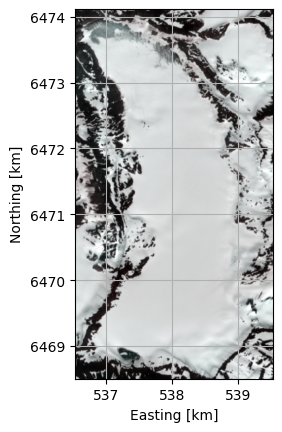

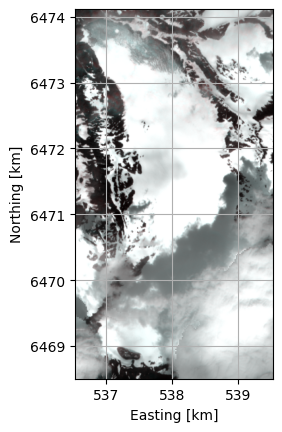

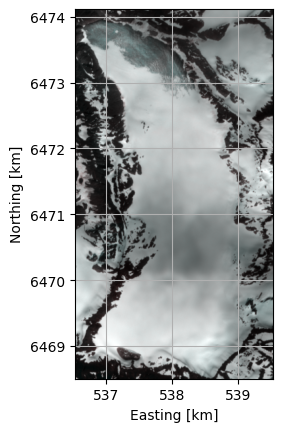

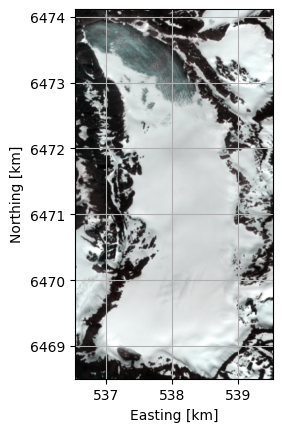

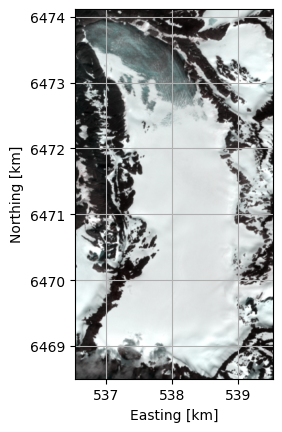

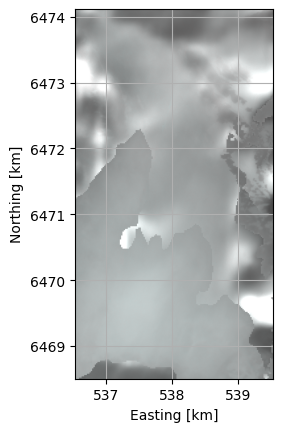

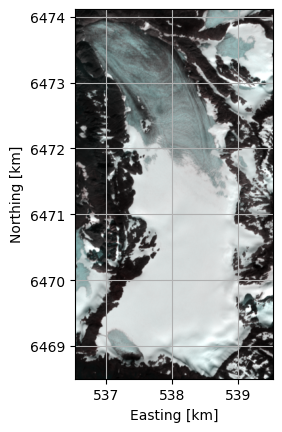

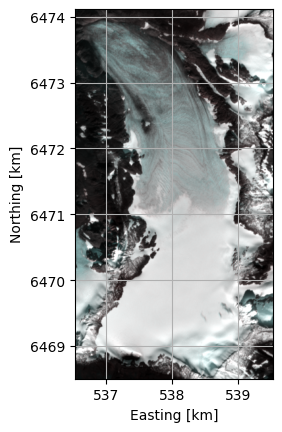

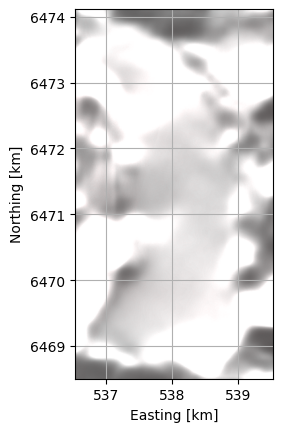

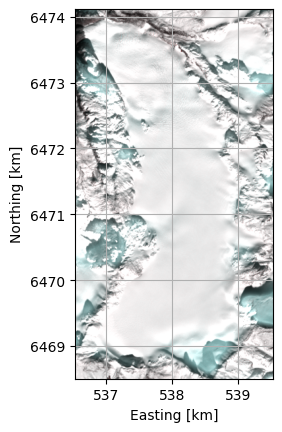

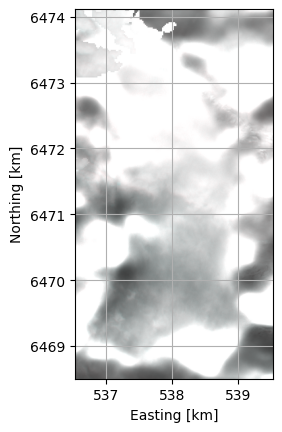

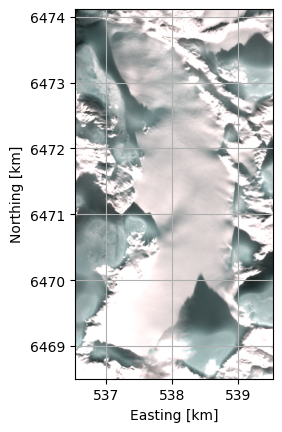

In [ ]:
# -----Iterate over site names
site_name = 'LemonCreek'

# load glacier outline shapefile (AOI)
AOI_path = study_sites_path + site_name + '/AOIs/'
AOI_fn = glob.glob(AOI_path + '*RGI*.shp')[0]
AOI = gpd.read_file(AOI_fn)
# reproject AOI to the optimal UTM zone
AOI_WGS = AOI.to_crs('EPSG:4326')  # make sure it's in WGS84 CRS
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0], AOI_WGS.geometry[0].centroid.xy[1][0]]  # grab the centroid of the glacier outline
epsg_UTM = convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1]) # grab optimal UTM zone
print('Optimal UTM CRS = EPSG:' + str(epsg_UTM))
AOI_UTM = AOI.to_crs('EPSG:' + str(epsg_UTM)) # reproject AOI to the optimal UTM zone

# define path for output images
out_path = study_sites_path + site_name + '/package_for_Ellyns_proposal/'

# query GEE for imagery
date_start = '2021-07-01'
date_end = '2021-11-30'
dataset = 'Sentinel-2_SR'
im_xr_list = query_gee_for_imagery(dataset_dict, dataset, AOI_UTM, date_start, date_end, month_start=5, month_end=11,
                                  cloud_cover_max=70, mask_clouds=False, out_path=out_path, im_download=True)

# plot image(s)
for im_xr in im_xr_list:
    RGB_bands = dataset_dict[dataset]['RGB_bands'] # grab RGB band names from dataset_dict
    plt.figure()
    plt.imshow(np.dstack([im_xr[RGB_bands[0]].data[0], # red
                          im_xr[RGB_bands[1]].data[0], # green
                          im_xr[RGB_bands[1]].data[0]  # blue
                          ]
                          ),
                extent=(np.min(im_xr.x.data) / 1e3, np.max(im_xr.x.data) / 1e3,
                        np.min(im_xr.y.data) / 1e3, np.max(im_xr.y.data) / 1e3)
    )
    plt.grid()
    plt.xlabel('Easting [km]')
    plt.ylabel('Northing [km]')
    plt.show()


In [ ]:
im_xr

'N'